https://www.cis.fordham.edu/wisdm/dataset.php

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

In [2]:
data_path = '../dataset/WISDM_at_v2.0/WISDM_at_v2.0_raw.txt'
max_interval = 1000
min_timestamp = 10
min_step = 10
freq = '50ms'

In [3]:
cache_path = 'cache_data.pkl'
if os.path.isfile(cache_path):
    print(f'loading {cache_path}')
    with open(cache_path, 'rb') as file:
        data = pickle.load(file)
else:
    print(f'writing {cache_path}')
    data = []
    with open(data_path, 'r') as file:
        prev_user = None
        prev_activity = None
        prev_timestamp = None
        series = None
        for line in tqdm(file):
            cols = line[:-2].split(',')

            if len(cols) != 6: continue

            user, activity, timestamp, x_acc, y_acc, z_acc = cols
            timestamp = int(timestamp)
            x_acc = float(x_acc)
            y_acc = float(y_acc)
            z_acc = float(z_acc)

            if timestamp < 0: continue

            item = (timestamp, activity, x_acc, y_acc, z_acc)
            if prev_user == user and prev_activity == activity and timestamp - prev_timestamp < max_interval:
                if prev_timestamp != timestamp:
                    series.append(item)
            else:
                series = [item]
                data.append(series)
            prev_user = user
            prev_activity = activity
            prev_timestamp = timestamp

    data = [series for series in data if len(series) >= min_timestamp]
    if 0:
        print('len(data)', len(data))
        for series in data:
            print(len(series), series[0])

    with open(cache_path, 'wb') as file:
        pickle.dump(data, file)

3005411it [00:09, 302603.25it/s]


In [4]:
cache_path = 'cache_WISDM.pkl'
if os.path.isfile(cache_path):
    print(f'loading {cache_path}')
    with open(cache_path, 'rb') as file:
        dfs = pickle.load(file)
else:
    print(f'writing {cache_path}')
    dfs = []
    for series in tqdm(data):
        df = pd.DataFrame(series)

        try:

            df.index = pd.to_datetime(df[[0]][0], unit='ms')

            df_type = df[[1]].resample(freq).nearest()

            df_acc = df[[2, 3, 4]].resample(freq).mean().interpolate(method='linear')

            df = df_type.join(df_acc)

            if len(df) < min_step: continue
            dfs.append(df)
        except:
            print(df)

    with open(cache_path, 'wb') as file:
        pickle.dump(dfs, file)

100%|███████████████████████████████████████████████████████████████████████████████| 785/785 [00:07<00:00, 102.94it/s]


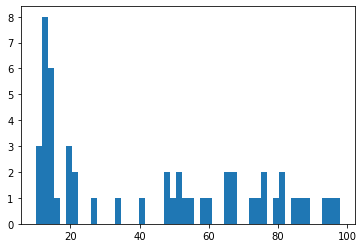

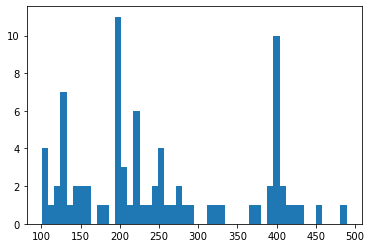

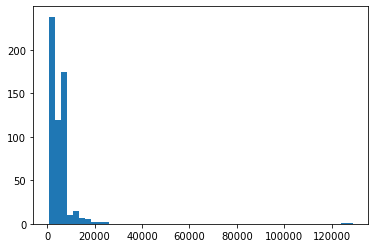

In [14]:
if 0:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.hist([len(df) for df in [df for df in dfs if len(df) < 100]], 50)
    plt.show()
    plt.hist([len(df) for df in [df for df in dfs if 100 <= len(df) < 500]], 50)
    plt.show()
    plt.hist([len(df) for df in [df for df in dfs if len(df) >= 500]], 50)
    plt.show()

In [9]:
len(dfs)

710

In [10]:
np.amin([len(df) for df in dfs])

10